In [1]:
import warnings, gc
import numpy as np 
import pandas as pd
import matplotlib.colors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
from decimal import ROUND_HALF_UP, Decimal
from tqdm import tqdm
import pickle
import jpx_tokyo_market_prediction

warnings.filterwarnings("ignore")
import plotly.figure_factory as ff

init_notebook_mode(connected = True)
temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), width=800))
colors = px.colors.qualitative.Plotly

In [2]:
# LightGBM training parameters
lgbm_cv_params = {
    'n_estimators': 100,
    'num_leaves' : 100,
    'learning_rate': 0.1,
    'colsample_bytree': 0.5,
    'subsample': 0.8,
    'reg_alpha': 0.4,
    'metric': 'mae',
    'random_state': 21,
    'verbosity': 1,
    'force_col_wise': True,
    'deterministic': True
}

lgbm_submit_params = {
    'n_estimators': 3000,
    'num_leaves' : 100,
    'learning_rate': 0.1,
    'colsample_bytree': 0.9,
    'subsample': 0.8,
    'reg_alpha': 0.4,
    'metric': 'mae',
    'random_state': 21,
    'verbosity': 1,
    'force_col_wise': True,
    'deterministic': True
}

In [3]:
# Read csv files

def load_data():
    print('load_data()')
    
    dataset_dir="../input/jpx-tokyo-stock-exchange-prediction/train_files"
    supplemental_dataset_dir="../input/jpx-tokyo-stock-exchange-prediction/supplemental_files"

    df_stock_list = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")
    df_stock_list['Name'] = [i.rstrip().lower().capitalize() for i in df_stock_list['Name']]
    df_stock_list['SectorName'] = [i.rstrip().lower().capitalize() for i in df_stock_list['17SectorName']]
    df_stock_list['SectorCode'] = [i for i in df_stock_list['17SectorCode']]
    df_stock_list['SectorCode'] = df_stock_list['SectorCode'].replace('-', '0').fillna('0')

    # List of data files
    inputs = {
        "financials": [f"{dataset_dir}/financials.csv", f"{supplemental_dataset_dir}/financials.csv"],
        #"options": [f"{dataset_dir}/options.csv", f"{supplemental_dataset_dir}/options.csv"],
        #"secondary_stock_prices": [f"{dataset_dir}/secondary_stock_prices.csv", f"{supplemental_dataset_dir}/secondary_stock_prices.csv"],
        "stock_prices": [f"{dataset_dir}/stock_prices.csv", f"{supplemental_dataset_dir}/stock_prices.csv"],
        #"trades": [f"{dataset_dir}/trades.csv", f"{supplemental_dataset_dir}/trades.csv"]
    }

    # dict_input is a dict of raw input dataframes
    dict_input = dict()

    example_test_files = {}
    for k, v in tqdm(inputs.items()):
        _dfs = dict()
        for file_name in v:
            if 'trades.csv' in file_name:
                _dfs[file_name] = pd.read_csv(file_name, parse_dates = ['PublishedDate'])
            else:
                _dfs[file_name] = pd.read_csv(file_name, parse_dates = ['Date'])

        dict_input[k] = pd.concat(_dfs).reset_index(drop = True)

        if k in ['financials', 'secondary_stock_prices', 'stock_prices']:
            dict_input[k] = dict_input[k].merge(df_stock_list[['SecuritiesCode', 'Name', 'SectorCode']], on = 'SecuritiesCode', how = 'left')
            dict_input[k]['SectorCode'] = dict_input[k]['SectorCode'].fillna('0').astype(int)
            dict_input[k].sort_values(['Date', 'SecuritiesCode'], inplace = True)
        else:
            dict_input[k].sort_values('Date', inplace = True)

    for k, v in dict_input.items():
        print(v.info())

    # Dump to pickle file
    pickle.dump(dict_input, open('dict_input.pkl', 'wb'))

In [4]:
def adjust_price(df_price):
    def generate_adjusted_features(df):
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending = True)
        
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod().shift(1).fillna(1.0)
        
        # generate Adjusted prices
        for column in ["Close", "Open", "High", "Low", "Volume"]:
            df.loc[:, column] = (
                df[column] / df["CumulativeAdjustmentFactor"] if column != "Volume" else df[column] * df["CumulativeAdjustmentFactor"]
            ).map(lambda x: float(
                Decimal(str(x)).quantize(Decimal('0.1'), rounding = ROUND_HALF_UP)))
            df.loc[df[column] == 0, column] = np.nan
            
            # NaN handling
            if column == "Close":
                # First, forward fill for Close
                df.loc[:, column] = df.loc[:, column].ffill()
            elif column == "High" or column == "Low" or column == "Open":
                # High, Low and Open should be the same as Close
                df.loc[np.isnan(df[column]), column] = df.loc[np.isnan(df[column]), 'Close']
            else:
                # Volume should be 0
                df.loc[np.isnan(df[column]), column] = 0
            
        return df
    
    df_price = df_price.sort_values(["SecuritiesCode", "Date"], ascending = True)
    df_price = df_price.groupby("SecuritiesCode").apply(generate_adjusted_features).reset_index(drop = True)
    return df_price

def adjust_financial(df_financial):
    # Drop invalid row
    df_financial = df_financial[~df_financial['DisclosedTime'].isna()]
    
    # Extract only consolidated financial reports
    df_financial = df_financial[df_financial['TypeOfDocument'].str.contains('FinancialStatements_Consolidated')]

    # If disclosure time >= 15:00, we can't use the information on the day
    df_financial['DisclosedDateTime'] = pd.to_datetime(df_financial['DisclosedUnixTime'], unit = 's')
    df_financial['DisclosedDateTime'] = df_financial['DisclosedDateTime'].dt.tz_localize('utc').dt.tz_convert('Asia/Tokyo')
    df_financial['Date'] = df_financial['Date'] + (df_financial['DisclosedDateTime'].dt.hour >= 15) * timedelta(days = 1)
    
    # ToDo: Reflect financial revisions
    
    # Convert EPS and so on to float
    df_financial['EarningsPerShare'] = pd.to_numeric(df_financial["EarningsPerShare"], errors = 'coerce').fillna(0)
    df_financial['ForecastEarningsPerShare'] = pd.to_numeric(df_financial["ForecastEarningsPerShare"], errors = 'coerce').fillna(0)
    df_financial['NetSales'] = pd.to_numeric(df_financial["NetSales"], errors = 'coerce').fillna(0)
    df_financial['Profit'] = pd.to_numeric(df_financial["Profit"], errors = 'coerce').fillna(0)
    df_financial['ForecastProfit'] = pd.to_numeric(df_financial["ForecastProfit"], errors = 'coerce').fillna(0)
    df_financial['EquityToAssetRatio'] = pd.to_numeric(df_financial["EquityToAssetRatio"], errors = 'coerce').fillna(0)
    df_financial['ForecastDividendPerShareAnnual'] = pd.to_numeric(df_financial["EquityToAssetRatio"], errors = 'coerce').fillna(0)
    
    return df_financial[['Date', 'SecuritiesCode', 'EarningsPerShare', 'ForecastEarningsPerShare', 'NetSales', 'Profit', 'ForecastProfit', 'EquityToAssetRatio', 'ForecastDividendPerShareAnnual']]

def adjust_data():
    print('adjust_data()')
    
    dict_input = pickle.load(open('dict_input.pkl', 'rb'))

    # Adjust financial data
    df_adjusted_financial = adjust_financial(dict_input['financials'])
    df_adjusted_financial.sort_values(["SecuritiesCode", "Date"], ascending = True, inplace = True)
    
    # Reflect AdjustmentFactor to price, etc...
    df_adjusted_price = adjust_price(dict_input['stock_prices'])
    df_adjusted_price.sort_values(["SecuritiesCode", "Date"], ascending = True, inplace = True)
    df_adjusted_price.drop(["RowId", "AdjustmentFactor", "CumulativeAdjustmentFactor", "ExpectedDividend"], axis = 1, inplace = True)
    
    # Dump to pickle file
    df_adjusted_price.to_pickle("df_adjusted_price.pkl")
    df_adjusted_financial.to_pickle("df_adjusted_financial.pkl")

In [5]:
# Calc recent sharpe ratio
def calc_sharpe():
    print('calc_sharpe()')
    
    df = pd.read_pickle('df_adjusted_price.pkl')
    df = df[df['Date'] < '2021-12-06']
                        
    df_closes = pd.pivot_table(df, values = "Close", index = "Date", columns = "SecuritiesCode").ffill()
    
    codes = df_closes.columns.unique()
    
    df_sharpe = pd.DataFrame()
    
    for code in codes:
        df_closes[code] = df_closes[code].pct_change()
        df_sharpe.loc[code, 'mean'] = df_closes[code].mean()
        df_sharpe.loc[code, 'std'] = df_closes[code].std()
    
    df_sharpe['sharpe'] = df_sharpe['mean'] / df_sharpe['std']    
    df_sharpe = df_sharpe.sort_values('sharpe', ascending = False)
    df_sharpe.to_pickle('df_sharpe.pkl')

In [6]:
# Features engineering
def ror(pivots, window):
    closes, opens, highs, lows, volumes = pivots
    ror = (closes - closes.shift(window)) / closes.shift(window)
    return pd.melt(ror.diff(), ignore_index = False).reset_index().dropna().rename(columns = {"value": f"ror_{window}_diff"})

def qvol(pivots, window):    
    closes, opens, highs, lows, volumes = pivots
    quote_volumes = (volumes * (closes + opens) / 2).rolling(window).mean()
    return pd.melt(quote_volumes.diff(), ignore_index=False).reset_index().dropna().rename(columns = {"value": f"qvol_{window}_diff"})

def atr(pivots, window):
    closes, opens, highs, lows, volumes = pivots
    a = highs - lows
    b = abs(highs - closes.shift(1))
    c = abs(lows - closes.shift(1))
    atr = pd.DataFrame(np.max([a,b,c], axis = 0) / closes.shift(1), index = a.index, columns = a.columns).rolling(window).mean()
    return pd.melt(atr.diff(), ignore_index=False).reset_index().dropna().rename(columns = {"value": f"atr_{window}_diff"})

def atr_day(pivots, window):    
    closes, opens, highs, lows, volumes = pivots
    a = (highs - lows) / closes.shift(1)
    atr_day = a.rolling(window).mean()
    return pd.melt(atr_day.diff(), ignore_index = False).reset_index().dropna().rename(columns = {"value": f"d_atr_{window}_diff"})

def atr_gaphigh(pivots, window):    
    closes, opens, highs, lows, volumes = pivots
    a = abs(highs - closes.shift(1)) / closes.shift(1)
    atr_gaphigh = a.rolling(window).mean()
    return pd.melt(atr_gaphigh.diff(), ignore_index = False).reset_index().dropna().rename(columns = {"value": f"hg_atr_{window}_diff"})

def atr_gaplow(pivots, window):
    closes, opens, highs, lows, volumes = pivots
    a = abs(lows - closes.shift(1)) / closes.shift(1)
    atr_gaplow = a.rolling(window).mean()
    return pd.melt(atr_gaplow.diff(), ignore_index = False).reset_index().dropna().rename(columns = {"value": f"lg_atr_{window}_diff"})

def vola(pivots, window):
    closes, opens, highs, lows, volumes = pivots
    vola = (closes.diff() / closes.shift(1)).rolling(window).std()
    return pd.melt(vola.diff(), ignore_index = False).reset_index().dropna().rename(columns = {"value": f"vola_{window}_diff"})

def HL(pivots, window):
    closes, opens, highs, lows, volumes = pivots
    hl = highs.rolling(window).max() - lows.rolling(window).min()
    return pd.melt(hl.diff(), ignore_index = False).reset_index().dropna().rename(columns = {"value": f"hl_{window}_diff"})

def market_impact(pivots, window):
    closes, opens, highs, lows, volumes = pivots
    mi = (closes.diff() / volumes).rolling(window).mean()
    return pd.melt(mi.diff(), ignore_index = False).reset_index().dropna().rename(columns = {"value": f"mi_{window}_diff"})

def ma_gap(pivots, window):
    closes, opens, highs, lows, volumes = pivots
    magap = (closes - closes.rolling(window).mean()) / closes.rolling(window).mean()
    return pd.melt(magap.diff(), ignore_index = False).reset_index().dropna().rename(columns = {"value": f"magap_{window}_diff"})

def create_technical_features(df_price):
    df = df_price.copy()
     
    closes = pd.pivot_table(df, values = "Close", index = "Date", columns = "SecuritiesCode").ffill()
    opens = pd.pivot_table(df, values = "Open", index = "Date", columns = "SecuritiesCode").ffill()
    highs = pd.pivot_table(df, values = "High", index = "Date", columns = "SecuritiesCode").ffill()
    lows = pd.pivot_table(df, values = "Low", index = "Date", columns = "SecuritiesCode").ffill()
    volumes = pd.pivot_table(df, values = "Volume", index = "Date", columns = "SecuritiesCode").ffill()
    
    pivots = (closes, opens, highs, lows, volumes)

    features = df[["Date", "SectorCode", "SecuritiesCode", "Close", "Open", "High", "Low", "Volume"]].fillna(0)
    
    for func in [vola, ma_gap]:
        for window in tqdm([2, 5, 10, 20, 40, 60, 100]):
            features = pd.merge(features, func(pivots, window), on = ["Date","SecuritiesCode"], how = "left")
    
    for func in [ror, qvol, atr, atr_day, atr_gaphigh, atr_gaplow, HL, market_impact]:
        for window in tqdm([1, 5, 10, 20, 40, 60, 100]):
            features = pd.merge(features, func(pivots, window), on = ["Date","SecuritiesCode"], how = "left")
    
    features['dateofweek'] = df['Date'].map(lambda x: datetime.fromtimestamp(x.value / 1_000_000_000).weekday())
    return features.drop(['Close', 'Open', 'High', 'Low', 'Volume'], axis = 1)    

def create_financial_features(df_financial):
    df = df_financial.copy()
    
    features = df[['Date', 'SecuritiesCode', 'EarningsPerShare', 'ForecastEarningsPerShare', 'NetSales', 'Profit', 'ForecastProfit', 'EquityToAssetRatio', 'ForecastDividendPerShareAnnual']]
    features['eps'] = features['EarningsPerShare']
    features['feps'] = features['ForecastEarningsPerShare']
    features['eps_feps'] = (features['eps'] / features['feps']).replace([np.inf, -np.inf], np.nan).fillna(0)
    features['pmargin'] = (features['Profit'] / features['NetSales']).replace([np.inf, -np.inf], np.nan).fillna(0)
    features['earatio'] = features['EquityToAssetRatio']
    features['fdps'] = features['ForecastDividendPerShareAnnual']
    
    # ToDo: Forecast missing, Revisions, etc...

    return features.drop(['EarningsPerShare', 'ForecastEarningsPerShare', 'NetSales', 'Profit', 'ForecastProfit', 'EquityToAssetRatio', 'ForecastDividendPerShareAnnual'], axis = 1)

def calc_features():
    print('calc_features()')
    
    dict_input = pd.read_pickle('dict_input.pkl')
    df_adjusted_price = pd.read_pickle('df_adjusted_price.pkl')
    df_adjusted_financial = pd.read_pickle('df_adjusted_financial.pkl')
    
    df_technical_features = create_technical_features(df_adjusted_price)
    df_technical_features = df_technical_features.sort_values(['Date','SecuritiesCode']).dropna(axis = 0)
    
    df_financial_features = create_financial_features(df_adjusted_financial)
    df_financial_features = df_financial_features.sort_values(['Date','SecuritiesCode']).fillna(0)
                
    df_features = df_technical_features.merge(df_financial_features, on = ['Date', 'SecuritiesCode'], how = 'left')
    df_features['eps'] = df_features['eps'].ffill().fillna(0)
    df_features['feps'] = df_features['feps'].ffill().fillna(0)
    df_features['eps_feps'] = df_features['eps_feps'].ffill().fillna(0)
    df_features['pmargin'] = df_features['pmargin'].ffill().fillna(0)
    df_features['earatio'] = df_features['earatio'].ffill().fillna(0)
    df_features['fdps'] = df_features['fdps'].ffill().fillna(0)
    
    df_features = df_technical_features
    df_features_target = df_features.merge(dict_input['stock_prices'][['Date', 'SecuritiesCode', 'Target']], on = ['Date', 'SecuritiesCode'], how = 'left').dropna(axis = 0)
    
    print(df_features_target.info())

    # Dump to file and free memory
    df_features_target.to_pickle('df_features_target.pkl')

In [7]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [8]:
def run_train_cv():
    df_features_target = pd.read_pickle('df_features_target.pkl')

    ts_fold = TimeSeriesSplit(n_splits = 10, gap = 7)
    
    date_features_target = df_features_target.Date.unique()

    df_X = df_features_target[set(df_features_target.columns.values) - {'Target'}]
    df_y = df_features_target[['Date', 'Target']]

    feat_importance = pd.DataFrame()
    sharpe_ratio = []

    for fold, (train_idx, valid_idx) in enumerate(ts_fold.split(date_features_target, date_features_target)):
        train_from = date_features_target[train_idx[0]]
        train_to = date_features_target[train_idx[-1]]
        valid_from = date_features_target[valid_idx[0]]
        valid_to = date_features_target[valid_idx[-1]]
        
        print(f"\n========================== Fold {fold + 1} ==========================")
        X_train, y_train = df_X[(df_X['Date'] >= train_from) & (df_X['Date'] <= train_to)], df_y[(df_y['Date'] >= train_from) & (df_y['Date'] <= train_to)]
        X_valid, y_valid = df_X[(df_X['Date'] >= valid_from) & (df_X['Date'] <= valid_to)], df_y[(df_y['Date'] >= valid_from) & (df_y['Date'] <= valid_to)]

        print(f"Train Date range: {X_train.Date.min()} to {X_train.Date.max()}")
        print(f"Valid Date range: {X_valid.Date.min()} to {X_valid.Date.max()}")

        val_dates = X_valid.Date.unique()[1:-1]
        X_train_nodate = X_train.drop('Date', axis = 1)
        X_valid_nodate = X_valid.drop('Date', axis = 1)
        y_train_nodate = y_train.drop('Date', axis = 1)
        y_valid_nodate = y_valid.drop('Date', axis = 1)
        print(f"\nTrain Shape: {X_train_nodate.shape} {y_train_nodate.shape}, Valid Shape: {X_valid_nodate.shape} {y_valid_nodate.shape}")

        gbm = LGBMRegressor(**lgbm_cv_params).fit(X_train_nodate, y_train_nodate,
                                                  eval_set = [(X_train_nodate, y_train_nodate), (X_valid_nodate, y_valid_nodate)],
                                                  verbose = 250)
        y_pred = gbm.predict(X_valid_nodate)
        rmse = np.sqrt(mean_squared_error(y_valid_nodate, y_pred))
        mae = mean_absolute_error(y_valid_nodate, y_pred)
        feat_importance["Importance_Fold" + str(fold)] = gbm.feature_importances_
        feat_importance.set_index(X_train_nodate.columns, inplace = True)

        rank = []
        for i in X_valid.Date.unique():
            temp_df = X_valid[X_valid.Date == i].drop('Date', axis = 1)
            temp_df["pred"] = gbm.predict(temp_df)
            temp_df["Rank"] = (temp_df["pred"].rank(method = "first", ascending = False) - 1).astype(int)
            rank.append(temp_df["Rank"].values)

        stock_rank = pd.Series([x for y in rank for x in y], name = "Rank")
        df = pd.concat([X_valid.reset_index(drop = True), stock_rank, df_features_target['Target'].reset_index(drop = True)], axis = 1)
        sharpe = calc_spread_return_sharpe(df)
        sharpe_ratio.append(sharpe)
        print(f"Valid Sharpe: {sharpe}, RMSE: {rmse}, MAE: {mae}")

        # Free memory
        del X_train, y_train,  X_valid, y_valid, X_train_nodate, X_valid_nodate, y_train_nodate, y_valid_nodate
        gc.collect()

    print(f"\nAverage cross-validation Sharpe Ratio: {np.mean(sharpe_ratio):.4f}, standard deviation = {np.std(sharpe_ratio):.2f}.")

    # Plot feature importance
    feat_importance['avg'] = feat_importance.mean(axis = 1)
    feat_importance = feat_importance.sort_values(by = 'avg', ascending = True)
    pal = sns.color_palette("plasma_r", len(feat_importance.index) + 2).as_hex()[2:]

    fig = go.Figure()
    for i in range(len(feat_importance.index)):
        fig.add_shape(dict(type = "line", y0 = i, y1 = i, x0 = 0, x1 = feat_importance['avg'][i], 
                           line_color = pal[::-1][i], opacity = 0.7, line_width = 4))
    fig.add_trace(go.Scatter(x=feat_importance['avg'], y = feat_importance.index, mode = 'markers', 
                             marker_color = pal[::-1], marker_size = 8,
                             hovertemplate = '%{y} Importance = %{x:.0f}<extra></extra>'))
    fig.update_layout(template = temp, title = 'Overall Feature Importance', 
                      xaxis = dict(title = 'Average Importance', zeroline = False),
                      yaxis_showgrid = False, margin = dict(l = 120, t = 80),
                      height = 2000, width = 800)
    fig.show()

In [9]:
def run_train_all():
    df_features_target = pd.read_pickle('df_features_target.pkl')
    df_sharpe = pd.read_pickle('df_sharpe.pkl')
    
    # Low sharpe ratio stocks
    list_securitiescode = list(df_sharpe.index[200:-200])
    
    # Fit with all training date for submission
    X_train = df_features_target[df_features_target['Date'] < '2021-12-06'][set(df_features_target.columns.values) - {'Target'}]
    y_train = df_features_target[df_features_target['Date'] < '2021-12-06'][['Date', 'Target']]
    X_test = df_features_target[df_features_target['Date'] >= '2021-12-06'][set(df_features_target.columns.values) - {'Target'}]
    y_test = df_features_target[df_features_target['Date'] >= '2021-12-06'][['Date', 'Target']]
    
    print(f"Train Date range: {X_train.Date.min()} to {X_train.Date.max()}")
    print(f"Test Date range: {X_test.Date.min()} to {X_test.Date.max()}")
    
    X_train_nodate = X_train.drop('Date', axis = 1)
    X_test_nodate = X_test.drop('Date', axis = 1)
    y_train_nodate = y_train.drop('Date', axis = 1)
    y_test_nodate = y_test.drop('Date', axis = 1)

    gbm = LGBMRegressor(**lgbm_submit_params).fit(X_train_nodate, y_train_nodate, verbose = 250)
    pickle.dump(gbm, open('model.pkl', 'wb'))
    
    # Run against test period
    y_pred = gbm.predict(X_test_nodate)
    rmse = np.sqrt(mean_squared_error(y_test_nodate, y_pred))
    mae = mean_absolute_error(y_test_nodate, y_pred)
    
    rank = []
    for i in X_test.Date.unique():
        temp_df = X_test[X_test.Date == i]
        temp_df["pred"] = gbm.predict(temp_df.drop('Date', axis = 1))
        median_pred = temp_df["pred"].median()
        
        # Ignore too high and too low predictions
        ignore_count = 1
        temp_df = temp_df.sort_values('pred', ascending = False)
        pred_index = temp_df.columns.get_loc('pred')
        temp_df.iloc[:ignore_count, pred_index] = median_pred
        temp_df.iloc[-ignore_count:, pred_index] = median_pred
        temp_df = temp_df.sort_index()
        
        # Set rank after the above adjustment
        temp_df["Rank"] = (temp_df["pred"].rank(method = "first", ascending = False) - 1).astype(int)
        temp_df["Rank"] = temp_df["Rank"].fillna(len(temp_df) // 2)
        rank.append(temp_df["Rank"].values)

    stock_rank = pd.Series([x for y in rank for x in y], name="Rank")
    df = pd.concat([X_test.reset_index(drop = True), stock_rank,
                   df_features_target[df_features_target['Date'] >= '2021-12-06']['Target'].reset_index(drop = True)], axis = 1)

    sharpe_ratio = []
    sharpe = calc_spread_return_sharpe(df)
    sharpe_ratio.append(sharpe)
    print(f"Validation sharpe: {sharpe}, RMSE: {rmse}, MAE: {mae}")
    
    df_feature_importance = pd.DataFrame()
    df_feature_importance['Name'] = gbm.feature_name_
    df_feature_importance['Importance'] = gbm.feature_importances_
    df_feature_importance.sort_values('Importance', ascending = True, inplace = True)

    pal = sns.color_palette("plasma_r", len(df_feature_importance) + 2).as_hex()[2:]
    fig = go.Figure()
    
    for i in range(len(df_feature_importance)):
        fig.add_shape(dict(type="line", y0 = i, y1 = i, x0 = 0, x1 = df_feature_importance['Importance'].iloc[i], 
                           line_color = pal[::-1][i], opacity = 0.7, line_width = 4))

    fig.add_trace(go.Scatter(x = df_feature_importance['Importance'], y = df_feature_importance['Name'], mode = 'markers', 
                  marker_color = pal[::-1], marker_size = 8,
                  hovertemplate = '%{y} Importance = %{x:.0f}<extra></extra>'))

    fig.update_layout(template = temp, title = 'Overall Feature Importance', 
                      xaxis = dict(title = 'Average Importance', zeroline = False),
                      yaxis_showgrid = False, margin = dict(l = 120, t = 80),
                      height = 2000, width = 800)
    fig.show()

In [10]:
def simulate_submit():
    env = jpx_tokyo_market_prediction.make_env()
    iter_test = env.iter_test()
    
    df_features_target = pd.read_pickle('df_features_target.pkl')
    df_sharpe = pd.read_pickle('df_sharpe.pkl')
    gbm = pickle.load(open('model.pkl', 'rb'))

    # Find should be excluded securities code based on highest 200 and lowest 200 sharpe ratio
    list_securitiescode = list(df_sharpe.index[200:-200])

    for (prices, options, financials, trades, secondary_prices, sample_prediction) in tqdm(iter_test):
        current_date = prices["Date"].iloc[0]
        print(f'Target date = {current_date}')

        df_features_temp = df_features_target[df_features_target["Date"] == current_date]
        
        df_features_temp["pred"] = gbm.predict(df_features_temp.drop(['Date', 'Target'], axis = 1))

        temp_df = df_features_temp[df_features_temp["Date"] == current_date][["Date", "SecuritiesCode", "pred"]]
        
        # Pick low volatility stocks and boost prediction to be picked as top 200 and bottom 200 stocks
        temp_df["pred_abs"] = np.abs(temp_df["pred"])
        
        temp_df2 = temp_df.sort_values('pred', ascending = False).reset_index()
        row_min_pred = temp_df2[temp_df2['pred_abs'] == temp_df2['pred_abs'].min()]
        min_index = row_min_pred.index.values.astype(int)[0]

        if min_index >= 0:
            min_index = min_index + 1

        df_plus = temp_df2.iloc[min_index - 200:min_index]
        list_plus = list(df_plus['index'])
        df_minus = temp_df2.iloc[min_index: min_index + 200]
        list_minus = list(df_minus['index'])

        temp_df.loc[list_plus, 'pred'] = temp_df.loc[list_plus, 'pred'] + 1
        temp_df.loc[list_minus, 'pred'] = temp_df.loc[list_minus, 'pred'] - 1
        
        # Set rank after the above adjustment
        temp_df["Rank"] = (temp_df["pred"].rank(method="first", ascending = False) - 1).astype(int)
        
        sample_prediction["Date"] = pd.to_datetime(sample_prediction["Date"])
        sample_prediction.drop("Rank", axis = 1, inplace = True)
        sample_prediction = sample_prediction.merge(temp_df[["Date", "SecuritiesCode", "Rank"]], on = ["Date", "SecuritiesCode"], how = "left")
        sample_prediction["Rank"] = sample_prediction["Rank"].fillna(len(sample_prediction) // 2)
        sample_prediction["Rank"] = (sample_prediction["Rank"].rank(method = "first") - 1).astype(int)

        assert sample_prediction["Rank"].notna().all()
        assert sample_prediction["Rank"].min() == 0
        assert sample_prediction["Rank"].max() == len(sample_prediction["Rank"]) - 1

        env.predict(sample_prediction)

load_data()


100%|██████████| 2/2 [00:16<00:00,  8.35s/it]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 102390 entries, 0 to 102389
Data columns (total 47 columns):
 #   Column                                                                        Non-Null Count   Dtype         
---  ------                                                                        --------------   -----         
 0   DisclosureNumber                                                              102388 non-null  float64       
 1   DateCode                                                                      102388 non-null  object        
 2   Date                                                                          102390 non-null  datetime64[ns]
 3   SecuritiesCode                                                                102388 non-null  float64       
 4   DisclosedDate                                                                 102388 non-null  object        
 5   DisclosedTime                                                                 1

100%|██████████| 7/7 [00:17<00:00,  2.53s/it]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2105221 entries, 0 to 2105224
Data columns (total 75 columns):
 #   Column           Dtype         
---  ------           -----         
 0   Date             datetime64[ns]
 1   SectorCode       int64         
 2   SecuritiesCode   int64         
 3   vola_2_diff      float64       
 4   vola_5_diff      float64       
 5   vola_10_diff     float64       
 6   vola_20_diff     float64       
 7   vola_40_diff     float64       
 8   vola_60_diff     float64       
 9   vola_100_diff    float64       
 10  magap_2_diff     float64       
 11  magap_5_diff     float64       
 12  magap_10_diff    float64       
 13  magap_20_diff    float64       
 14  magap_40_diff    float64       
 15  magap_60_diff    float64       
 16  magap_100_diff   float64       
 17  ror_1_diff       float64       
 18  ror_5_diff       float64       
 19  ror_10_diff      float64       
 20  ror_20_diff      float64       
 21  ror_40_diff      float64       

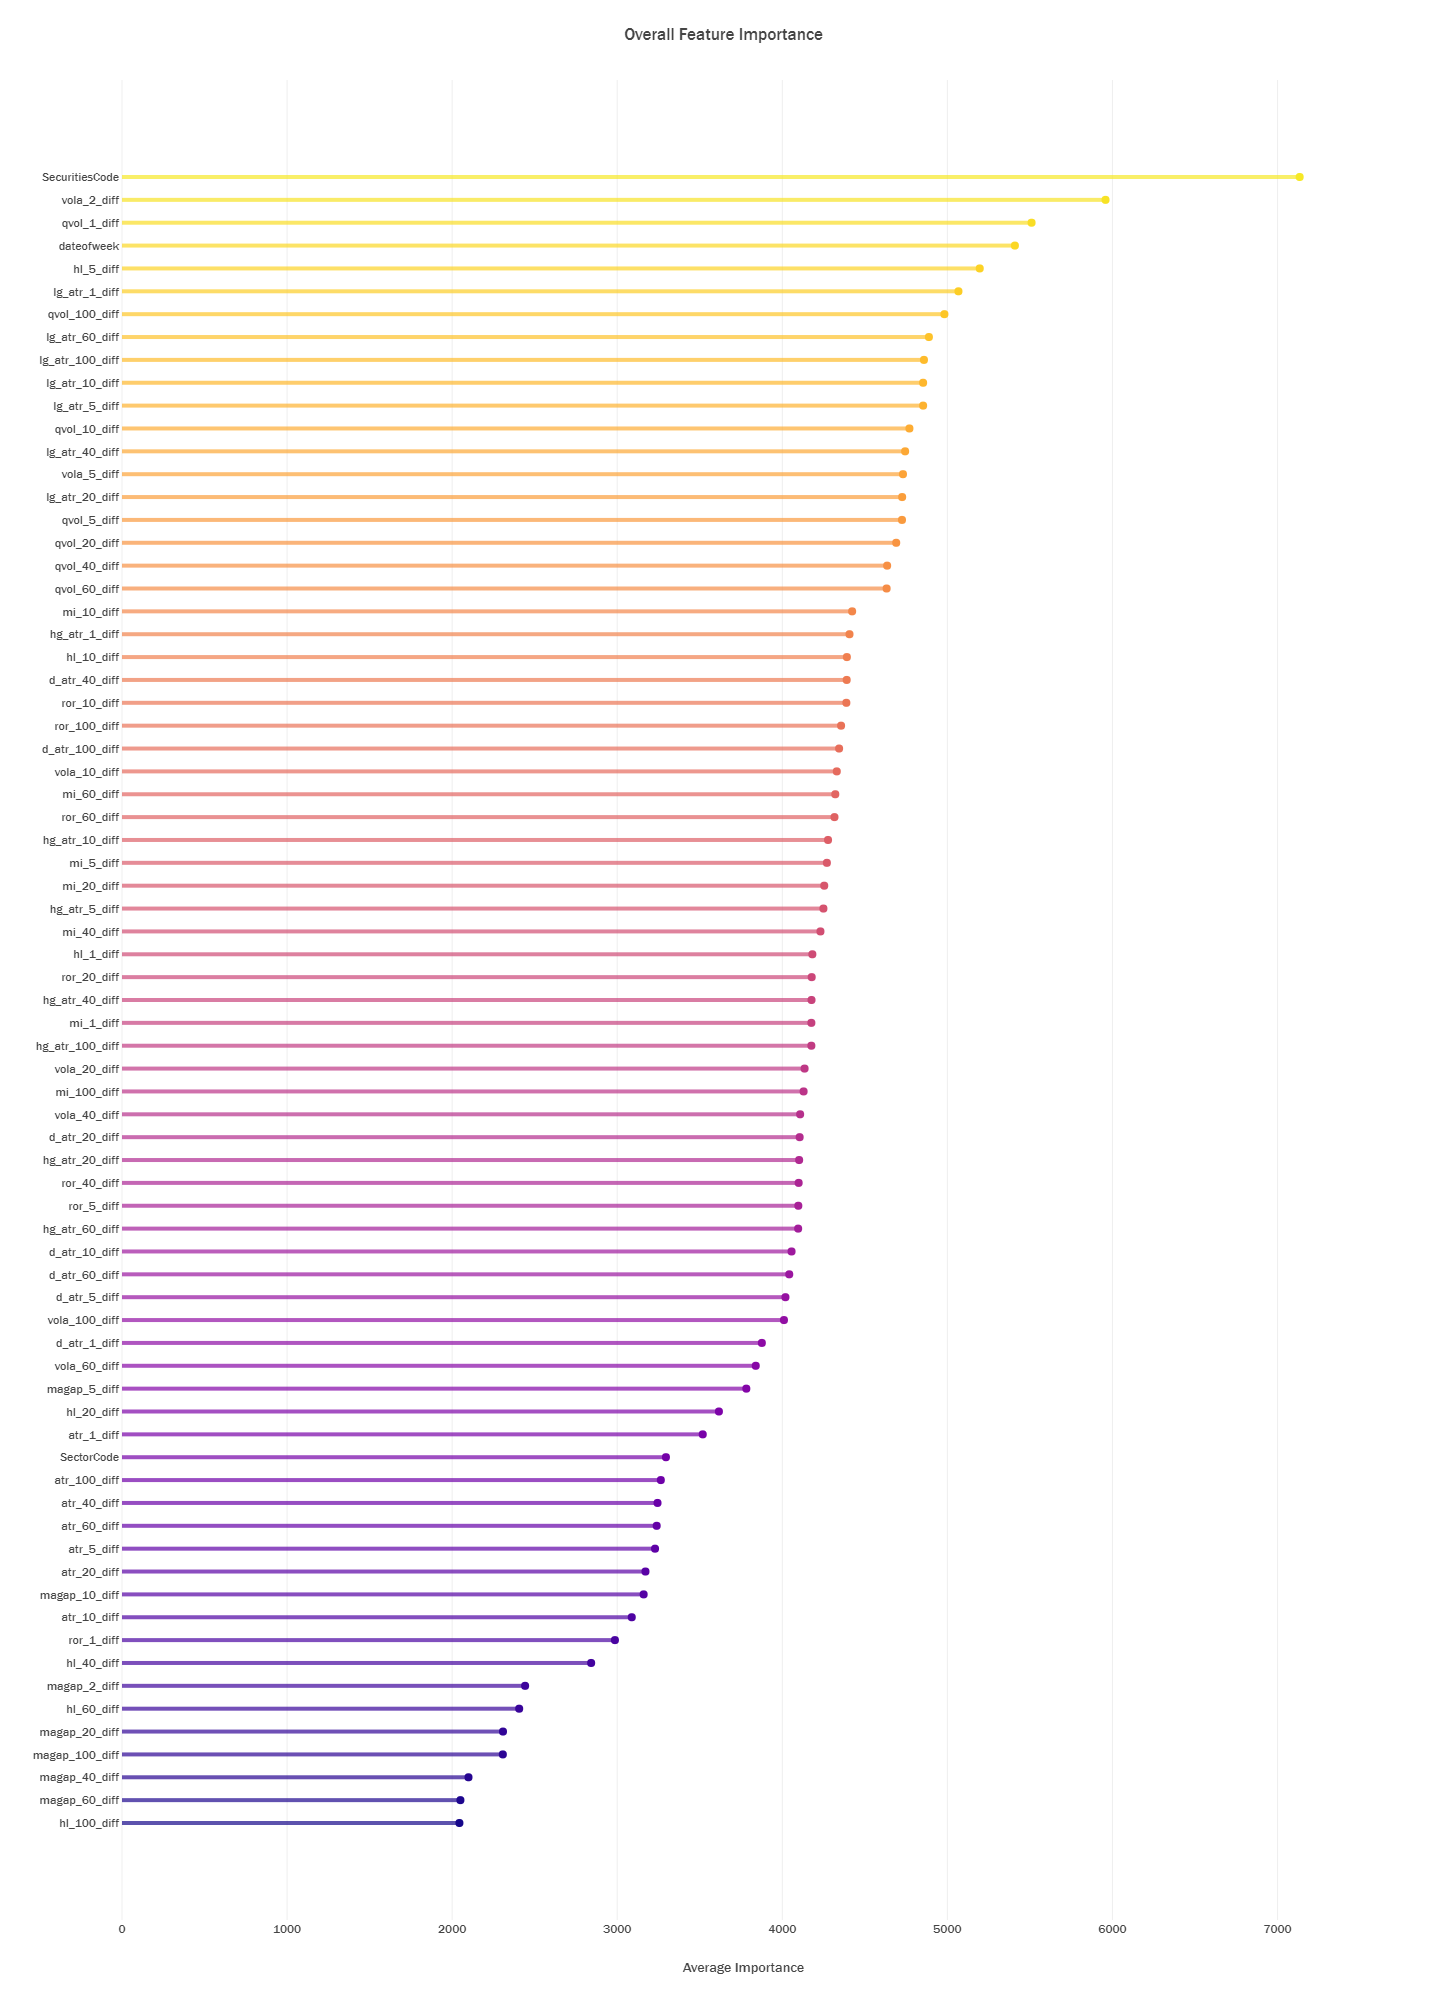

0it [00:00, ?it/s]

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Target date = 2021-12-06


1it [00:00,  2.55it/s]

Target date = 2021-12-07


2it [00:00,  3.01it/s]


In [11]:
# Test config
load_csv = False    # Load CSV
adjustment = False  # Adjust values
prepare_sharpe = False
prepare_df = False   # Prepare features dataframe
run_cv = False      # Run training and cross validation
run_all = True      # Run training for entire training data without validation
submit = True     # Simulate submission

# Fool proof
if submit == True:
    load_csv = True
    adjustment = True
    prepare_sharpe = True
    prepare_df = True
    run_cv = False
    run_all = True

pd.options.display.max_rows = 100
pd.options.display.max_columns = None

    # Read data from CSV file and save to pickle file
if load_csv == True:
    load_data()
    gc.collect()

# Apply adjustment factor and save to pickle file
if adjustment == True:
    adjust_data()
    gc.collect()

# Calc sharpe
if prepare_sharpe == True:
    calc_sharpe()
    gc.collect()
    
# Calc features and save to pickle file
if prepare_df == True:
    calc_features()
    gc.collect()

# Run training with CV
if run_cv:
    run_train_cv()
    gc.collect

# Run training with all training data
if run_all:
    run_train_all()
    gc.collect()

# Submit
if submit == True:
    simulate_submit()
    gc.collect()